In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Data.csv")

In [3]:
consistent_teams=['England','Australia','West Indies','India','Bangladesh','New Zealand','Pakistan','South Africa','Sri Lanka']

In [4]:
df=df[df['batting_team'].isin(consistent_teams)]

In [5]:
df=df[df['bowling_team'].isin(consistent_teams)]

In [6]:
df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')

In [7]:
df=df.sort_values(['match_id', 'innings'], ascending=[True, True])

In [8]:
df['overs']=df['ball']
df['ball'] = df['ball'].astype(str)
df['ball'].str[0:-1]
df['over']=df['ball'].str[0:-1]
df['over'].str.replace('.', '')
df['over']=df['over'].str.replace('.', '')
df['ball'].str[-1:]
df['ball']=df['ball'].str[-1:]

In [9]:
df['total_runs']=df['runs_off_bat']+df['extras']

In [10]:
df=df[['match_id','innings','batting_team','bowling_team','overs','over','ball','total_runs','player_dismissed']]

In [11]:
df=df.rename(columns={"match_id": "id"})

In [12]:
df = df.replace(np.nan, 0)

# Total runs scored in the innings

In [13]:
df.groupby(['id','innings'])['total_runs'].transform('sum')

354008    179
354009    179
354010    179
354011    179
354012    179
         ... 
329240     65
329241     65
329242     65
329243     65
329244     65
Name: total_runs, Length: 171497, dtype: int64

In [14]:
df['total']=df.groupby(['id','innings'])['total_runs'].transform('sum')

# Runs scored till the current ball

In [15]:
df.groupby(['id', 'innings'])['total_runs'].apply(lambda x: x.cumsum())

354008     0
354009     1
354010     1
354011     1
354012     1
          ..
329240    53
329241    59
329242    61
329243    61
329244    65
Name: total_runs, Length: 171497, dtype: int64

In [16]:
df['total_score']=df.groupby(['id', 'innings'])['total_runs'].apply(lambda x: x.cumsum())

# Runs scored in previous 30 balls

In [17]:
df.groupby(['id','innings'])['total_runs'].rolling(min_periods=1, window=30).sum().reset_index()

,id,innings,level_2,total_runs
0,211028,1,354008,0.0
1,211028,1,354009,1.0
2,211028,1,354010,1.0
3,211028,1,354011,1.0
4,211028,1,354012,1.0
...,...,...,...,...
171492,1399119,2,329240,53.0
171493,1399119,2,329241,59.0
171494,1399119,2,329242,60.0
171495,1399119,2,329243,60.0


In [18]:
tmp=df.groupby(['id','innings'])['total_runs'].rolling(min_periods=1, window=30).sum().reset_index()

In [19]:
tmp[['total_runs']]

,total_runs
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
171492,53.0
171493,59.0
171494,60.0
171495,60.0


In [20]:
df['prev_30_runs']=tmp['total_runs'].to_list()

# Wickets fallen in previous 30 balls

In [21]:
df['player_dismissed']=np.where(df['player_dismissed']==0, 0, 1)

In [22]:
tmp=df.groupby(['id','innings'])['player_dismissed'].rolling(min_periods=1, window=30).sum().reset_index()

df['prev_30_wickets']=tmp['player_dismissed'].to_list()

# Wickets fallen till the current ball

In [23]:
df.groupby(['id', 'innings'])['player_dismissed'].apply(lambda x: x.cumsum())

354008    0
354009    0
354010    0
354011    0
354012    0
         ..
329240    3
329241    3
329242    3
329243    4
329244    4
Name: player_dismissed, Length: 171497, dtype: int32

In [24]:
df['total_wickets']=df.groupby(['id', 'innings'])['player_dismissed'].apply(lambda x: x.cumsum())

# Dot balls in previous 30 balls

In [25]:
df['prev_30_dot_balls']=df['total_runs']
df['prev_30_dot_balls']=np.where(df['prev_30_dot_balls']==0, 1, 0)

tmp=df.groupby(['id','innings'])['prev_30_dot_balls'].rolling(min_periods=1, window=30).sum().reset_index()
df['prev_30_dot_balls']=tmp['prev_30_dot_balls'].to_list()

# Boundaries in previous 30 balls

In [26]:
df['prev_30_boundaries']=df['total_runs']
df['prev_30_boundaries']=np.where(df['prev_30_boundaries']>3, 1, 0)

tmp=df.groupby(['id','innings'])['prev_30_boundaries'].rolling(min_periods=1, window=30).sum().reset_index()
df['prev_30_boundaries']=tmp['prev_30_boundaries'].to_list()

# Runrate last 30 balls

In [27]:
df['run_rate'] = df.apply(lambda x : x['total_score'] / x['overs'], axis = 1)

df['runrate_last30balls'] = df.apply(lambda x : x['prev_30_runs'] / x['overs'], axis = 1)

In [28]:
convert_dict = {'prev_30_runs': int, 
                'prev_30_wickets': int,
                'prev_30_dot_balls':int,
                'prev_30_boundaries':int
               } 
  
df = df.astype(convert_dict) 

In [29]:
df.head()

,id,innings,batting_team,bowling_team,overs,over,ball,total_runs,player_dismissed,total,total_score,prev_30_runs,prev_30_wickets,total_wickets,prev_30_dot_balls,prev_30_boundaries,run_rate,runrate_last30balls
354008,211028,1,England,Australia,0.1,0,1,0,0,179,0,0,0,0,1,0,0.000000,0.000000
354009,211028,1,England,Australia,0.2,0,2,1,0,179,1,1,0,0,1,0,5.000000,5.000000
354010,211028,1,England,Australia,0.3,0,3,0,0,179,1,1,0,0,2,0,3.333333,3.333333
354011,211028,1,England,Australia,0.4,0,4,0,0,179,1,1,0,0,3,0,2.500000,2.500000
354012,211028,1,England,Australia,0.5,0,5,0,0,179,1,1,0,0,4,0,2.000000,2.000000


In [30]:
df = pd.get_dummies(data=df, columns=['batting_team', 'bowling_team'])

In [31]:
df=df[['id','batting_team_Australia','batting_team_Bangladesh', 'batting_team_England', 'batting_team_India','batting_team_New Zealand','batting_team_Pakistan', 
       'batting_team_South Africa', 'batting_team_Sri Lanka','batting_team_West Indies','bowling_team_Australia', 'bowling_team_Bangladesh', 'bowling_team_England',
        'bowling_team_India', 'bowling_team_New Zealand', 'bowling_team_Pakistan','bowling_team_South Africa', 'bowling_team_Sri Lanka','bowling_team_West Indies',
            'overs','total_score','total_wickets','prev_30_runs','prev_30_wickets','prev_30_dot_balls','prev_30_boundaries','total', 'run_rate', 'runrate_last30balls']]

# train_test_split

In [32]:
X = df.drop(labels=['total','id'], axis=1)
y = df['total'].values

In [33]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42,stratify=y)

In [34]:
X_train=X_train.values
X_test=X_test.values
X_train=np.asarray(X_train).astype(np.float32)
X_test=np.asarray(X_test).astype(np.float32)

In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(128622, 27) (42875, 27) (128622,) (42875,)


# Training LR model

In [36]:
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)

LinearRegression()

In [37]:
# Creating a pickle file for the classifier
filename = 'lr-model.pkl'
pickle.dump(LR_model, open(filename, 'wb'))

In [38]:
prediction=LR_model.predict(X_test)
mean_absolute_error (y_test, prediction)

18.70190783584639

In [39]:
# Function to predict scores :

def score_prediction(Bat_Team,Bowl_Team,overs,total_score,total_wickets,prev_runs_30,prev_wickets_30,prev_30_dot_balls,prev_30_boundaries,run_rate,runrate_last30balls):

    temp_array = list()

    if Bat_Team == 'AUS':
        temp_array = temp_array + [1,0,0,0,0,0,0,0,0]
    elif Bat_Team == 'BAN':
        temp_array = temp_array + [0,1,0,0,0,0,0,0,0]
    elif Bat_Team == 'ENG':
        temp_array = temp_array + [0,0,1,0,0,0,0,0,0]
    elif Bat_Team == 'IND':
        temp_array = temp_array + [0,0,0,1,0,0,0,0,0]
    elif Bat_Team == 'NZ':
        temp_array = temp_array + [0,0,0,0,1,0,0,0,0]
    elif Bat_Team == 'PAK':
        temp_array = temp_array + [0,0,0,0,0,1,0,0,0]
    elif Bat_Team == 'SA':
        temp_array = temp_array + [0,0,0,0,0,0,1,0,0]
    elif Bat_Team == 'SL':
        temp_array = temp_array + [0,0,0,0,0,0,0,1,0]
    elif Bat_Team == 'WI':
        temp_array = temp_array + [0,0,0,0,0,0,0,0,1]

    if Bowl_Team == 'AUS':
        temp_array = temp_array + [1,0,0,0,0,0,0,0,0]
    elif Bowl_Team == 'BAN':
        temp_array = temp_array + [0,1,0,0,0,0,0,0,0]
    elif Bowl_Team == 'ENG':
        temp_array = temp_array + [0,0,1,0,0,0,0,0,0]
    elif Bowl_Team == 'IND':
        temp_array = temp_array + [0,0,0,1,0,0,0,0,0]
    elif Bowl_Team == 'NZ':
        temp_array = temp_array + [0,0,0,0,1,0,0,0,0]
    elif Bowl_Team == 'PAK':
        temp_array = temp_array + [0,0,0,0,0,1,0,0,0]
    elif Bowl_Team == 'SA':
        temp_array = temp_array + [0,0,0,0,0,0,1,0,0]
    elif Bowl_Team == 'SL':
        temp_array = temp_array + [0,0,0,0,0,0,0,1,0]
    elif Bowl_Team == 'WI':
        temp_array = temp_array + [0,0,0,0,0,0,0,0,1]

    temp_array = temp_array + [overs,total_score,total_wickets,prev_runs_30,prev_wickets_30,prev_30_dot_balls,prev_30_boundaries,run_rate, runrate_last30balls]
    data = np.array([temp_array])
    my_prediction = int(LR_model.predict(data))

    print('Predicted score: ',my_prediction)
    print('Predicted score range: ',my_prediction - 18, 'to' , my_prediction + 18)

In [40]:
Bat_Team = 'IND' 

Bowl_Team = 'SA' 

overs = 13.6

total_score = 141 # current score

total_wickets = 3 # current wicket 

prev_runs_30 = 57 # runs in last 30 balls

prev_wickets_30 = 0 # wickets in last 30 balls

prev_30_dot_balls = 5 # dots in last 30 balls

prev_30_boundaries = 7 # boundaries in last 30 balls

run_rate = 10.37            # current run rate

runrate_last30balls = 9.5  # run_rate in last 30 balls

score_prediction(Bat_Team,Bowl_Team,overs,total_score,total_wickets,
                         prev_runs_30,prev_wickets_30,prev_30_dot_balls,prev_30_boundaries,run_rate, runrate_last30balls)

Predicted score:  197
Predicted score range:  179 to 215


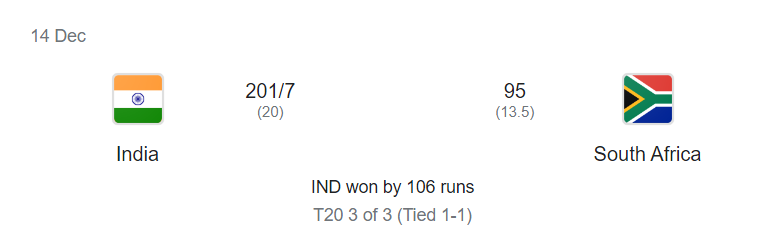

In [41]:
from IPython.display import Image
Image(filename='Screenshot 2024-01-10 173836.png') 